Goal: Apply Singular Value Decomposition (SVD) and K-means to nonprofit description data.

In [223]:
# All the imports belong in the top cell, so the remaining cells can use them.

# First import from the standard library
from collections import Counter

# Then import anything else you need

# Common to most data science projects:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Some specific methods we'll apply in this analysis:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

With `pandas`, we can conveniently read a data frame right from a URL.

In [225]:
d = pd.read_csv("https://raw.githubusercontent.com/clarkfitzg/stat129-spring25/refs/heads/main/llm/llm2.csv")
d

,ein,name,file,summary,mission
0,432058621,ACHLA ALIANZA CHICANA HISP LAT AMER ALLI,/stat129/tax23/202301389349200310_public.xml,help migrant families education health enrichment,ASSIST MIGRANT/IMMIGRANT FAMILES EXPERIENCING ...
1,850492047,GLOBAL SPOKES INC,/stat129/tax23/202311219349301116_public.xml,Provide bicycles buy repair immigrant,PROVIDE BICYCLES TO IMMIGRANT INDIVIDUALS. PUR...
2,550790330,COPTIC ORTHODOX CHARITIES INC,/stat129/tax23/202310129349301266_public.xml,Help refugees immigrants achieve self sufficiency,"TO ASSIST, REFUGEES, ASLYEES, ABUSED SPOUSES, ..."
3,942238257,LA RAZA COMMUNITY RESOURCE CENTER,/stat129/tax23/202331359349316993_public.xml,Help Latino families achieve self-sufficiency ...,LA RAZA COMMUNITY RESOURCE CENTER IS A MULTI- ...
4,222685077,VOLUNTEER ENGLISH PROGRAM,/stat129/tax23/202323459349300762_public.xml,Connect volunteers language learners empower i...,TO CONNECT VOLUNTEERS WITH ADULT ENGLISH LANGU...
...,...,...,...,...,...
3537,814590860,QUADW MISSIONAL OUTREACH,/stat129/tax23/202303059349300615_public.xml,Transform serve connect multiply,QUADW MISSIONAL OUTREACH DEVELOPS YOUNG ADULTS...
3538,311478557,SPIRIT OF CONSTRUCTION FOUNDATION OF,/stat129/tax23/202333189349302308_public.xml,Support construction industry and educate stud...,TO SUPPORT THE LOCAL CONSTRUCTION INDUSTRY AND...
3539,391871776,NATIONAL ASSOCIATION OF LANDSCAPE,/stat129/tax23/202320889349300947_public.xml,Strengthen industry through education scholars...,SEE SCHEDULE O THE NALP FOUNDATION WILL STRENG...
3540,237374620,BRANDYWINE WORKSHOP AND ARCHIVES,/stat129/tax23/202311359349312236_public.xml,Visual artist printmaking education training e...,VISUAL ARTIST PRINTMAKING VISUAL ARTIST PRINTM...


Missing values are going to be a problem for us if we try to use the `mission` column.

In [227]:
# Deal with missing values
sum(pd.isna(d['mission']))

1

Let's replace the missing values with an empty string, `""`.

In [229]:
d.loc[pd.isna(d['mission']), 'mission'] = ""

We'll use the `summary` column as the corpus. We could also use `mission`.

If we wanted to remove stop words, or do other text preprocessing, then we would put those steps in here.

In [231]:
corpus = d["summary"]
tf = TfidfVectorizer()
X = tf.fit_transform(corpus)
X.shape

(3542, 2071)

What words show up frequently?

In [233]:
terms = tf.get_feature_names_out()
wordcounts = X.sum(axis = 0)
# drop the 2 dimensional structure
wordcounts = np.ravel(wordcounts)
rank = np.argsort(wordcounts)

# Sorted by number of times they appear
terms_popular = terms[rank]
terms_popular[-10:]

array(['services', 'immigrants', 'college', 'help', 'and', 'community',
       'provide', 'education', 'students', 'support'], dtype=object)

## SVD- Singular Value Decomposition

The singular value decomposition takes our original high dimensional sparse data and projects it into a lower dimensional dense linear subspace, reducing the number of dimensions. We can choose how many dimensions we want.

In [235]:
ndim = 50
svd = TruncatedSVD(n_components=ndim, random_state=230)
svd.fit(X)

# These are the principal components
Xpc = svd.transform(X)

Xpc

array([[ 1.56753913e-01, -1.38243866e-01,  5.66105434e-03, ...,
         5.99231631e-02, -1.09358258e-01, -1.29241551e-01],
       [ 8.46752032e-02, -1.57309270e-02,  3.99068937e-02, ...,
         1.02461309e-02,  4.39631175e-02,  6.20331650e-03],
       [ 1.38412771e-01, -2.17773314e-01,  1.67292374e-01, ...,
         4.23172995e-02, -6.46238625e-05, -5.96579419e-02],
       ...,
       [ 1.80509025e-01,  1.67408360e-02, -6.60704298e-02, ...,
         8.80530620e-02, -3.86248902e-02, -3.02194964e-02],
       [ 4.51001599e-02, -1.38455088e-02, -1.67962401e-02, ...,
         2.48655629e-03, -2.67214567e-02,  3.63343891e-02],
       [ 1.22939325e-01,  3.09009500e-02, -1.43894109e-02, ...,
         4.74614183e-03,  3.36922142e-02, -7.56567860e-02]])

In [236]:
Xpc.shape

(3542, 50)

We're now in a 50 dimensional space, where it's easier to do k-means clustering.

Text(0, 0.5, 'percentage explained variance')

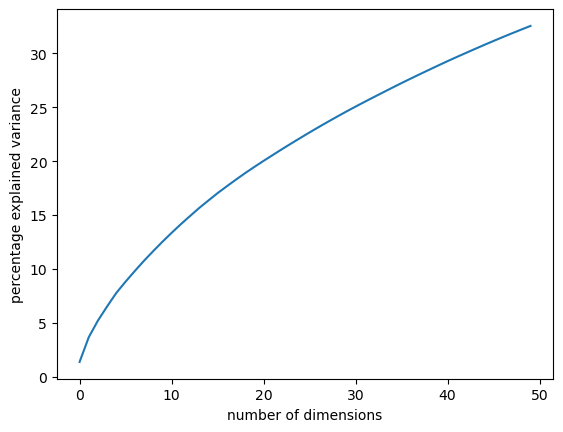

In [238]:
plt.plot(100 * np.cumsum(svd.explained_variance_ratio_))
plt.xlabel("number of dimensions")
plt.ylabel("percentage explained variance")

This plot shows that with 50 dimensions, we preserved and represented about 35% of the total variability in the data set.

## k-means

Let's fit our k-means model

In [266]:
K = 2

# The argument to random_state is an arbitrary integer to pick different initial points for the cluster centers.
# Not all of them are effective!
km = KMeans(n_clusters=K, random_state=546651)

clusters = km.fit_predict(Xpc)

In [268]:
# How many are in each cluster?
Counter(clusters)

Counter({1: 2733, 0: 809})

One cluster had 2733 points, the other 809.

In [270]:
# What are the centers?
Xcenters = svd.inverse_transform(km.cluster_centers_)
# Do this if we're not using the Principal components
#Xcenters = km.cluster_centers_

# An index of which terms have the largest coefficients
# in each cluster
bigindex = np.argsort(Xcenters)
for i in range(K):
    # The 3 most important terms in each cluster
    print(terms[bigindex[i, :]][-3:])

['help' 'services' 'immigrants']
['college' 'support' 'students']


In [272]:
# Let's look at 4 random documents from cluster 1
g = clusters == 1
gdocs = corpus[g]
np.random.choice(gdocs, size=4, replace=True)

array(['Support charity education community industry',
       'Assimilate immigrant provide education food shelter',
       'support students develop excellence',
       'Transforming political culture justice'], dtype=object)